In [1]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np
from src.dataset.dataset import SimpleIterDataset, EventDataset
from src.utils.utils import to_filelist
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rc('font', size=13)
from src.plotting.plot_event import plot_event_comparison
from src.dataset.functions_data import concat_events

In [2]:

def remove_from_list(lst):
    out = []
    for item in lst:
        if item in ["hgcal", "data.txt", "test_file.root"]:
            continue
        out.append(item)
    return out

#path = "/eos/user/g/gkrzmanc/jetclustering/data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.7_alpha-peak"
def get_iter(path, full_dataloader):
    if full_dataloader:
        datasets = os.listdir(path)
        datasets = [os.path.join(path, x) for x in datasets]
        datasets = datasets[:10]

        class Args:
            def __init__(self):
                self.data_train = datasets
                self.data_val = datasets
                #self.data_train = files_train
                self.data_config = '/work/gkrzmanc/jetclustering/code/config_files/config_jets_2_delphes.yaml'
                self.extra_selection = None
                self.train_val_split = 0.8
                self.data_fraction = 1
                self.file_fraction = 1
                self.fetch_by_files = False
                self.fetch_step = 0.2
                self.steps_per_epoch = None
                self.in_memory = False
                self.local_rank = None
                self.copy_inputs = False
                self.no_remake_weights = False
                self.batch_size = 10
                self.num_workers = 0
                self.demo = False
                self.laplace = False
                self.diffs = False
                self.class_edges = False

        args = Args()
        train_range = (0, args.train_val_split)
        train_file_dict, train_files = to_filelist(args, 'train')
        train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                                       extra_selection=args.extra_selection,
                                       remake_weights=True,
                                       load_range_and_fraction=(train_range, args.data_fraction),
                                       file_fraction=args.file_fraction,
                                       fetch_by_files=args.fetch_by_files,
                                       fetch_step=args.fetch_step,
                                       infinity_mode=False,
                                       in_memory=args.in_memory,
                                       async_load=False,
                                       name='train', jets=True)

        iterator = iter(train_data)
    else:
        iterator = iter(EventDataset.from_directory(path))
    return iterator
def get_histogram(path, full_dataloader=True):
    iterator = get_iter(path, full_dataloader)
    pt_jet = []
    pt_jet_all = []
    njets = []
    njets_gen = []
    jet_pt_gen = []
    jet_mass, jet_mass_filtered = [], []
    jet_area, jet_area_filtered = [], []
    met_pt_lst, met_phi_lst = [], []
    n = 0
    while True:
        try:
            data = next(iterator)
            n += 1
            njgen = len(data.genjets)
            nj = len(data.jets)
            j_m = data.jets.mass.tolist()
            jet_mass += list(j_m)
            njets.append(nj)
            njets_gen.append(njgen)
            jet_pt = data.jets.pt.tolist()
            met_pt = data.MET.pt.item()
            met_phi = data.MET.phi.item()
            met_pt_lst.append(met_pt)
            met_phi_lst.append(met_phi)
            pt_jet_all += list(jet_pt)
            gen_jet_pt = data.genjets.pt.tolist()
            jet_pt_gen += list(gen_jet_pt)
            if nj < 2:
                continue
            jet_eta = data.jets.eta.tolist()
            max_idx = np.argmax(jet_pt)
            if jet_pt[max_idx] < 100 or abs(jet_eta[max_idx]) > 2.4:
                continue
            pt_jet.append(jet_pt[max_idx])
            jet_mass_filtered += list(j_m)
        except StopIteration:
            break
    #len(pt_jet), n
    return pt_jet, n, jet_mass, jet_area, njets, jet_mass_filtered, jet_area_filtered, pt_jet_all, jet_pt_gen, njets_gen, met_pt_lst, met_phi_lst

In [3]:
dataset = get_iter("/work/gkrzmanc/jetclustering/LJP/out2", full_dataloader=1)

['/work/gkrzmanc/jetclustering/LJP/out2/out_5_eflowmerger2.root']
=== Restarting DataIter train, seed=None ===


In [4]:
n_pfc = []
pfc_pt = []
from tqdm import tqdm
for i in tqdm(range(500)):
    data = next(dataset)
    n_pfc.append(len(data.pfcands) - (data.pfcands.pt<0.5).sum())
    pfc_pt += torch.log10(data.pfcands.pt).tolist()

100%|██████████| 500/500 [00:03<00:00, 125.09it/s]


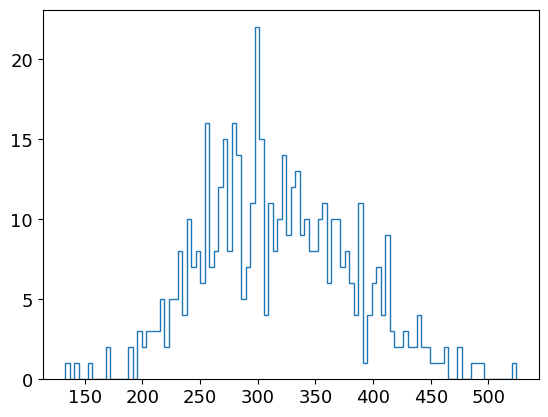

In [5]:
fig, ax = plt.subplots()
ax.hist(n_pfc, bins=100, histtype="step", label="Charged hadrons")
fig.show()


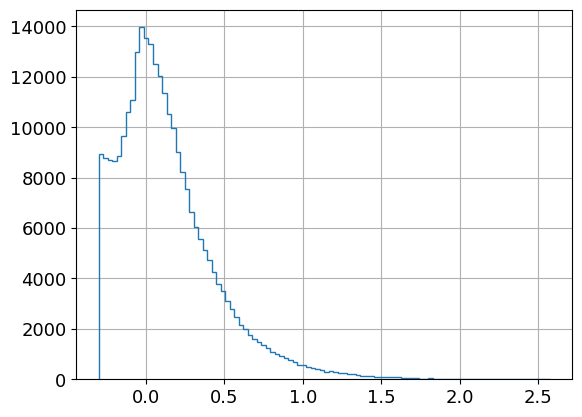

In [9]:

fig, ax = plt.subplots()
ax.hist(pfc_pt, bins=100, histtype="step", label="Charged hadrons")
ax.grid(1)
fig.show()


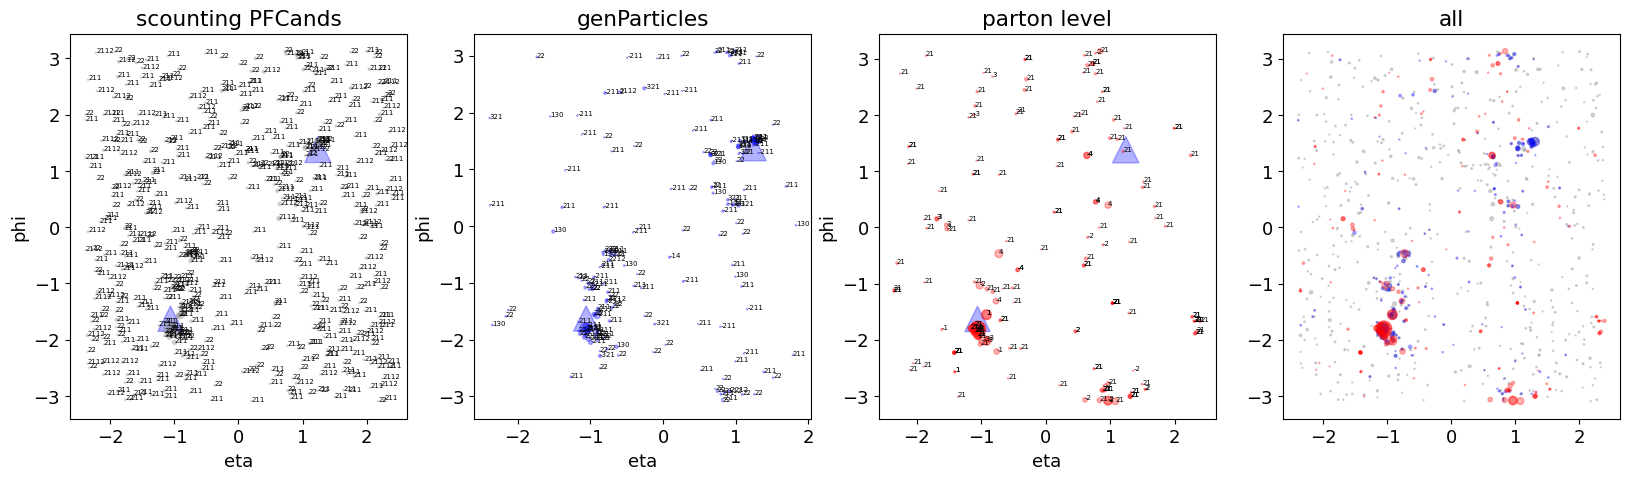

In [6]:
evt = next(dataset)
labels = ["scounting PFCands", "genParticles", "parton level"]
colors = ["gray", "blue", "red"]
classes = ["pfcands", "final_gen_particles", "final_parton_level_particles"]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(3):
    pt = getattr(evt, classes[i]).pt
    eta = getattr(evt, classes[i]).eta
    phi = getattr(evt, classes[i]).phi
    eta_dq, phi_dq  = evt.matrix_element_gen_particles.eta, evt.matrix_element_gen_particles.phi
    pt_dq = evt.matrix_element_gen_particles.pt
    ax[i].scatter(eta_dq, phi_dq, s=pt_dq, color="blue", alpha=0.3, marker="^")
    ax[i].scatter(eta, phi, s=pt, color=colors[i], alpha=0.3)
    ax[i].set_title(labels[i])
    ax[i].set_xlabel("eta")
    ax[i].set_ylabel("phi")
    ax[-1].scatter(eta, phi, s=pt, color=colors[i], alpha=0.3, label=labels[i])
    # Put PID where the circles are
    for j, txt in enumerate(getattr(evt, classes[i]).pid):
        ax[i].annotate(txt.int().item(), (eta[j], phi[j]), size=5)
ax[-1].set_title("all")
fig.savefig("/work/gkrzmanc/jetclustering/results/event_with_PIDs_PU_1.pdf")
fig.show()

In [6]:
1/0

ZeroDivisionError: division by zero

In [4]:
ds = EventDataset.from_directory("/work/gkrzmanc/jetclustering/preprocessed_data/scouting_PFNano_signals2/SVJ_hadronic_std/s-channel_mMed-900_mDark-20_rinv-0.3")

In [5]:
e = concat_events([ds[0], ds[1], ds[2], ds[3]])
def get_idx_for_event(obj, i):
    return obj.batch_number[i], obj.batch_number[i+1]

def get_labels_jets(b, pfcands, jets):
    # b: Batch of events
    R = 0.8
    labels = torch.zeros(len(pfcands)).long()
    for i in range(len(b)):
        s, e = get_idx_for_event(jets, i)
        dq_eta = jets.eta[s:e]
        dq_phi = jets.phi[s:e]
        s, e = get_idx_for_event(pfcands, i)
        pfcands_eta = pfcands.eta[s:e]
        pfcands_phi = pfcands.phi[s:e]
        # calculate the distance matrix between each dark quark and pfcands
        dist_matrix = torch.cdist(
            torch.stack([dq_eta, dq_phi], dim=1),
            torch.stack([pfcands_eta, pfcands_phi], dim=1),
            p=2
        )
        dist_matrix = dist_matrix.T
        closest_quark_dist, closest_quark_idx = dist_matrix.min(dim=1)
        closest_quark_idx[closest_quark_dist > R] = -1
        labels[s:e] = closest_quark_idx
    return (labels>=0).float()
get_labels_jets(e, e.pfcands, e.fatjets)

tensor([1., 1., 1.,  ..., 1., 1., 1.])

N jets: 4
Red circle: (fat)jets, blue star: genjet, red triangle: dark quark,
gray triangle: PFCand satisfying certain criteria - fields with Electrons, Muons, Photons
Fatjet = AK8, jet = AK4


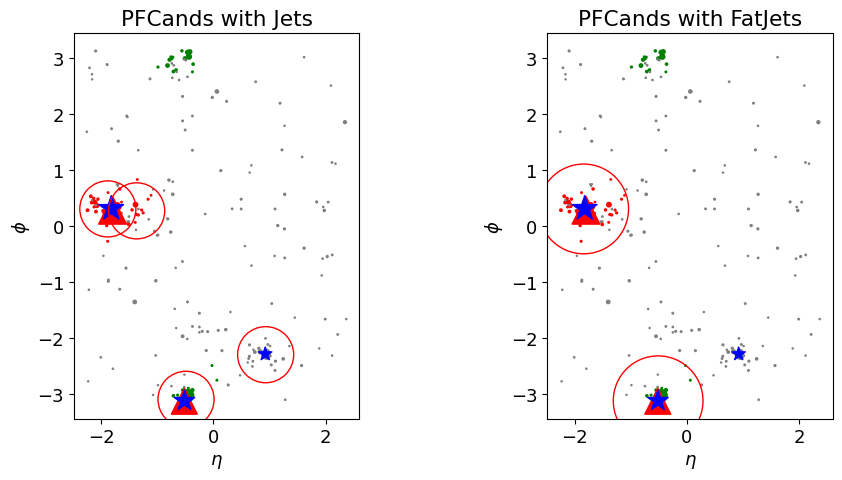

In [6]:
data = next(dataset)
plot_event_comparison(data).show()
print("Red circle: (fat)jets, blue star: genjet, red triangle: dark quark,")
print("gray triangle: PFCand satisfying certain criteria - fields with Electrons, Muons, Photons")
print("Fatjet = AK8, jet = AK4")

In [11]:
data.pfcands.pt[data.pfcands.pid==2]

tensor([4.3327, 4.0157])

tensor([ 31, 225])

(tensor([-0.7817, -1.5188]), tensor([2.9668, 0.0652]))

In [14]:
R=0.8
jets = [data.fatjets.eta, data.fatjets.phi]
dq = [data.matrix_element_gen_particles.eta, data.matrix_element_gen_particles.phi]
# calculate deltaR between each jet and each quark
distance_matrix = np.zeros((len(data.fatjets), len(data.matrix_element_gen_particles)))
for i in range(len(data.fatjets)):
    for j in range(len(data.matrix_element_gen_particles)):
        deta = jets[0][i] - dq[0][j]
        dphi = jets[1][i] - dq[1][j]
        distance_matrix[i, j] = np.sqrt(deta**2 + dphi**2)
# row-wise argmin
distance_matrix = distance_matrix.T
#min_distance = np.min(distance_matrix, axis=1)
if len(data.fatjets):
    quark_to_jet = np.min(distance_matrix, axis=1)
    quark_to_jet[quark_to_jet > R] = -1
    filt = quark_to_jet == -1
else:
    filt = torch.ones(len(data.matrix_element_gen_particles)).bool()
    quark_to_jet = torch.ones(len(data.matrix_element_gen_particles)).long() * -1

visible_E_event = torch.sum(data.pfcands.E) #+ torch.sum(data.special_pfcands.E)
print("quark_to_jet:", quark_to_jet)
matched_quarks = np.where(quark_to_jet != -1)[0]
for i in range(len(data.matrix_element_gen_particles)):
    dq_coords = [dq[0][i], dq[1][i]]
    cone_filter = torch.sqrt((data.pfcands.eta - dq_coords[0])**2 + (data.pfcands.phi - dq_coords[1])**2) < R
    #cone_filter_special = torch.sqrt(
    #    (data.special_pfcands.eta - dq_coords[0]) ** 2 + (data.special_pfcands.phi - dq_coords[1]) ** 2) < R
    E_in_cone = data.pfcands.E[cone_filter].sum() #+ data.special_pfcands.E[cone_filter_special].sum()
    print("Matched?:", i in matched_quarks, "frac_E_in_cone:", E_in_cone / visible_E_event)

quark_to_jet: [0.03256156 0.10826813]
Matched?: True frac_E_in_cone: tensor(0.2263)
Matched?: True frac_E_in_cone: tensor(0.2795)


In [5]:
np.linalg.norm(data.matrix_element_gen_particles.pxyz, axis=1), data.matrix_element_gen_particles.mass

(array([ 921.4706, 1422.0653], dtype=float32), tensor([10., 10.]))

N jets: 2
N special PFCands: 5


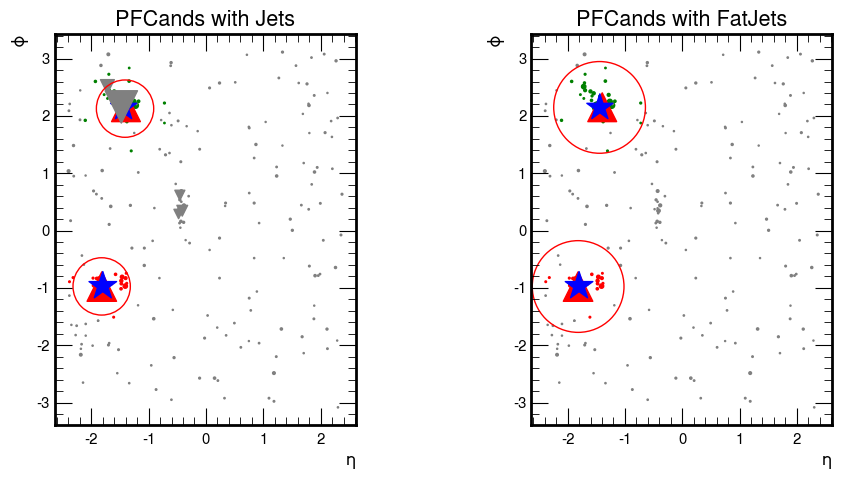

In [6]:
plot_event_comparison(data, special_pfcands_size=10).show()

In [7]:
np.sqrt(data.matrix_element_gen_particles.E**2 - np.linalg.norm(data.matrix_element_gen_particles.pxyz, axis=1)**2)

tensor([10.0031, 10.0000])

In [8]:
paths = {
    0.3: "/eos/user/g/gkrzmanc/jetclustering/data/scouting_PFNano_signals/SVJ_hadronic_std/s-channel_mMed-800_mDark-20_rinv-0.3",
    0.5: "/eos/user/g/gkrzmanc/jetclustering/data/scouting_PFNano_signals/SVJ_hadronic_std/s-channel_mMed-800_mDark-20_rinv-0.5",
    0.7: "/eos/user/g/gkrzmanc/jetclustering/data/scouting_PFNano_signals/SVJ_hadronic_std/s-channel_mMed-800_mDark-20_rinv-0.7"
}
#paths = {
#    0.3: "/eos/user/g/gkrzmanc/jetclustering/preprocessed_data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.3_alpha-peak",
#    0.5: "/eos/user/g/gkrzmanc/jetclustering/preprocessed_data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.5_alpha-peak",
#    0.7: "/eos/user/g/gkrzmanc/jetclustering/preprocessed_data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.7_alpha-peak"
#}



In [9]:
results = {}
for rinv in paths:
    print(rinv)
    results[rinv] = get_histogram(paths[rinv], full_dataloader=True)

0.3
['/eos/user/g/gkrzmanc/jetclustering/data/scouting_PFNano_signals/SVJ_hadronic_std/s-channel_mMed-800_mDark-20_rinv-0.3/PFNano_s-channel_mMed-800_mDark-20_rinv-0.3_alpha-peak_13TeV-pythia8_n-1000_part-10.root', '/eos/user/g/gkrzmanc/jetclustering/data/scouting_PFNano_signals/SVJ_hadronic_std/s-channel_mMed-800_mDark-20_rinv-0.3/PFNano_s-channel_mMed-800_mDark-20_rinv-0.3_alpha-peak_13TeV-pythia8_n-1000_part-12.root', '/eos/user/g/gkrzmanc/jetclustering/data/scouting_PFNano_signals/SVJ_hadronic_std/s-channel_mMed-800_mDark-20_rinv-0.3/PFNano_s-channel_mMed-800_mDark-20_rinv-0.3_alpha-peak_13TeV-pythia8_n-1000_part-14.root', '/eos/user/g/gkrzmanc/jetclustering/data/scouting_PFNano_signals/SVJ_hadronic_std/s-channel_mMed-800_mDark-20_rinv-0.3/PFNano_s-channel_mMed-800_mDark-20_rinv-0.3_alpha-peak_13TeV-pythia8_n-1000_part-15.root', '/eos/user/g/gkrzmanc/jetclustering/data/scouting_PFNano_signals/SVJ_hadronic_std/s-channel_mMed-800_mDark-20_rinv-0.3/PFNano_s-channel_mMed-800_mDark-20_r

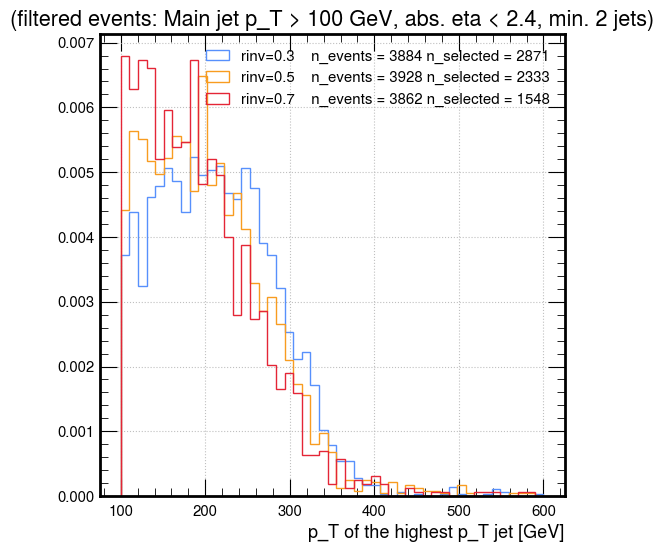

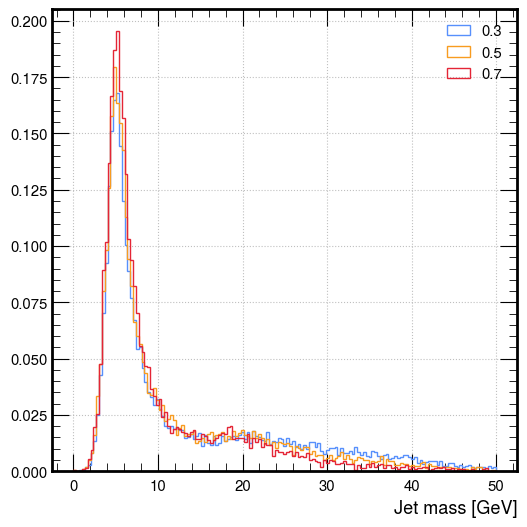

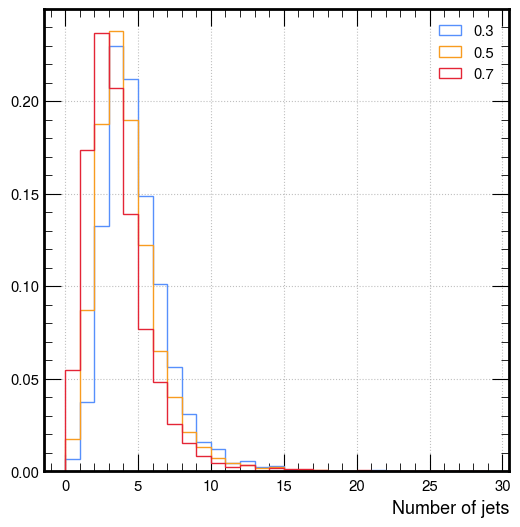

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
figmass, axmass = plt.subplots(figsize=(6, 6))
fig_nj, ax_nj = plt.subplots(figsize=(6, 6))

bins = np.linspace(100, 600, 50)
bins_mass = np.linspace(0, 50, 150)
bins_area = np.linspace(0.49, 0.51, 150)
bins_nj = list(range(30))

for key in results:
    result = results[key]
    ax.hist(result[0], bins=bins, label="rinv=" + str(key) + "    n_events = " + str(result[1]) + " n_selected = " + str(len(result[0])) , histtype="step", density=True)
    axmass.hist(result[2], bins=bins_mass, label=str(key), density=True, histtype="step")
    ax_nj.hist(result[4], bins=bins_nj, label=str(key), density=True, histtype="step")
    #axmass.hist(result[4], bins=bins_mass, label=str(key) + " filtered", density=True, histtype="step")

ax.legend()
ax.grid()
ax.set_title('(filtered events: Main jet p_T > 100 GeV, abs. eta < 2.4, min. 2 jets)')
ax.set_xlabel("p_T of the highest p_T jet [GeV]")

axmass.grid()
axmass.set_xlabel("Jet mass [GeV]")
axmass.legend()
ax_nj.legend()
ax_nj.grid()
ax_nj.set_xlabel("Number of jets")

fig.show()
figmass.show()
fig_nj.show()

In [11]:
pt = results[0.3][7]
pt_gen=  results[0.3][8]

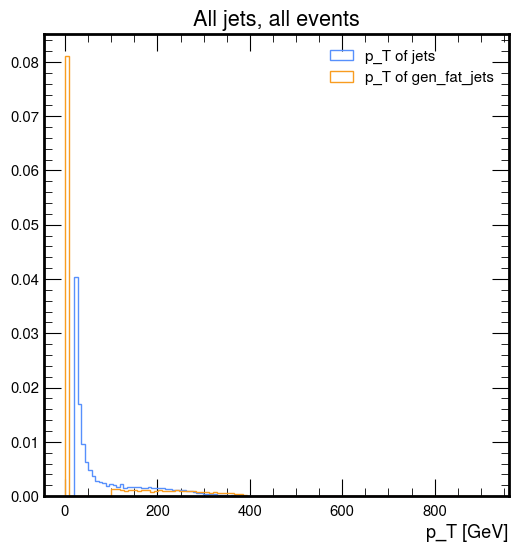

In [12]:
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(pt, bins=100, histtype="step", density=True, label="p_T of jets")
ax.hist(pt_gen, bins=100, histtype="step", density=True, label="p_T of gen_fat_jets")
ax.legend()
ax.set_title("All jets, all events")
ax.set_xlabel("p_T [GeV]")
fig.show()

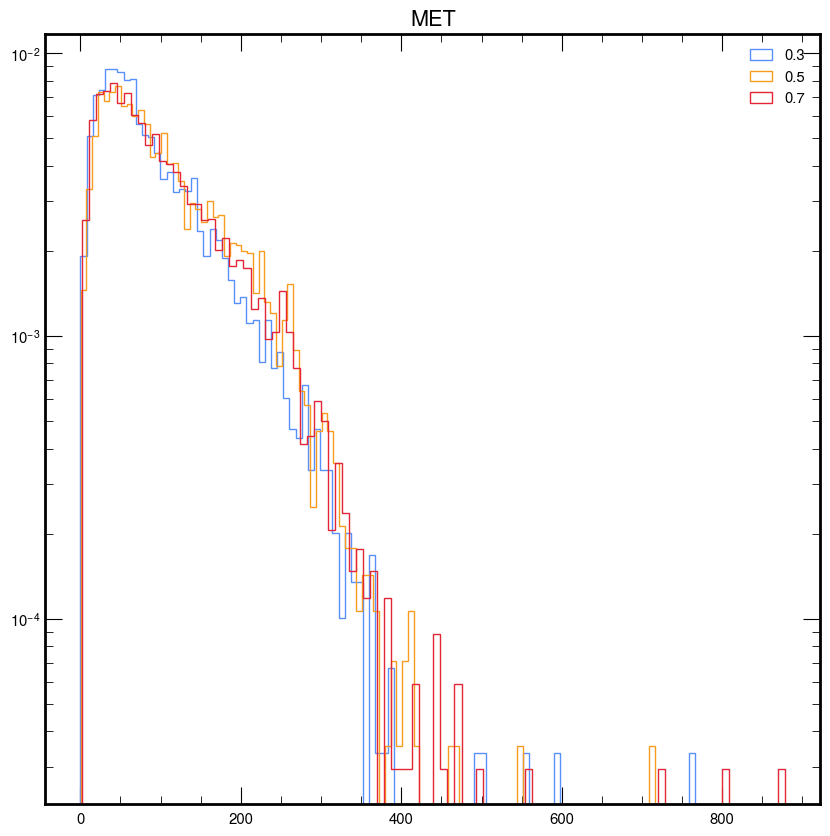

In [16]:
fig, ax = plt.subplots()
ax.hist(results[0.3][10], bins=100, histtype="step", density=True, label="0.3")
ax.hist(results[0.5][10], bins=100, histtype="step", density=True, label="0.5")
ax.hist(results[0.7][10], bins=100, histtype="step", density=True, label="0.7")
ax.set_yscale("log")
ax.legend()
ax.set_title("MET")
fig.show()


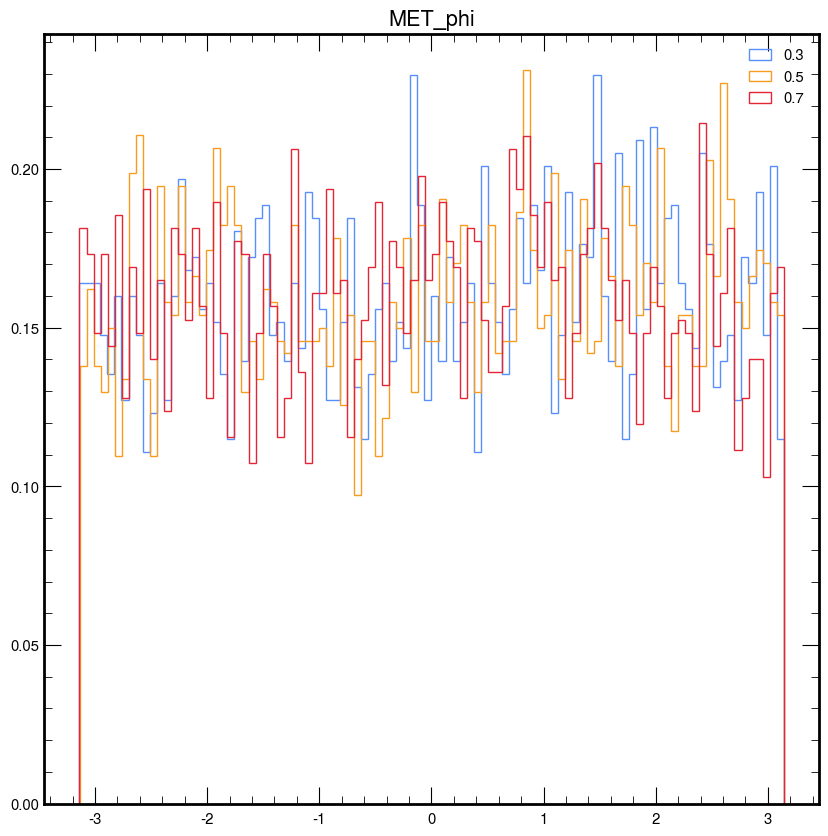

In [17]:
fig, ax = plt.subplots()
ax.hist(results[0.3][11], bins=100, histtype="step", density=True, label="0.3")
ax.hist(results[0.5][11], bins=100, histtype="step", density=True, label="0.5")
ax.hist(results[0.7][11], bins=100, histtype="step", density=True, label="0.7")
ax.legend()
ax.set_title("MET_phi")
fig.show()

